# Experimental Results on the Toy exemple

## Imports of the libraries and our functions

In [3]:
#imports
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

import scipy as sp
import scipy.linalg as spl
import scipy.stats as sps
import time
import pandas as pd

import matplotlib.pyplot as plt

In [63]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from our_package import * #allows us to use our functions directly

## Set up parameters

In [64]:
Lambda = 300
T = 30
#param_accept = 0.3

## Checking the behavior of Y (mean of L2-norm part in distribution used for RW), x (reproduction rate) and x_tilde (second-derivative of reproduction rate)

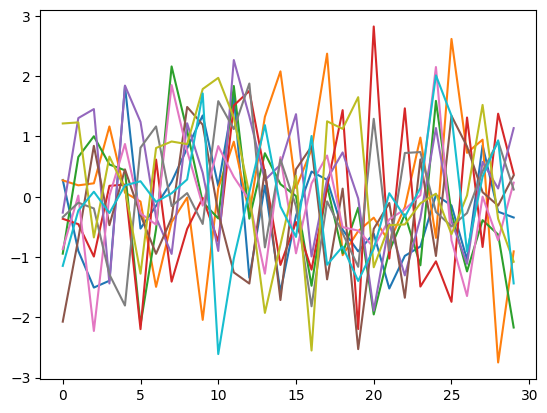

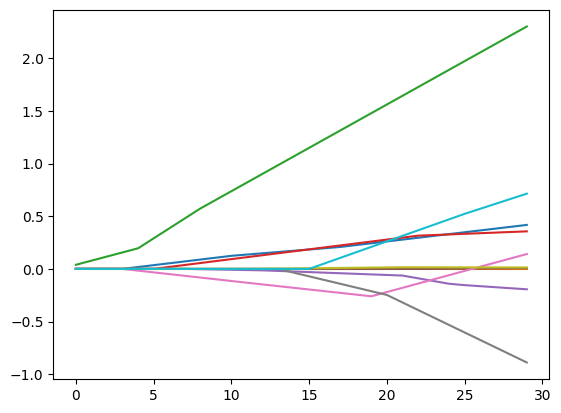

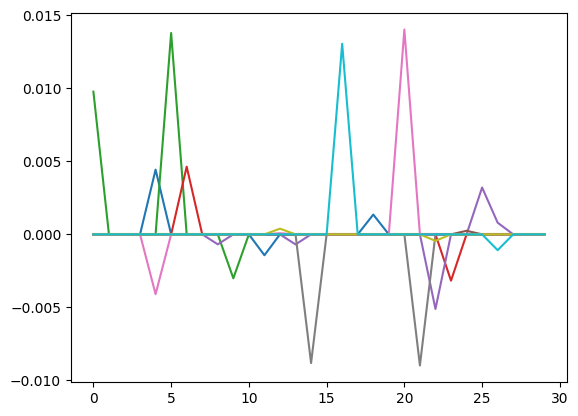

In [33]:
taille_echant = 10
Y = np.zeros((taille_echant, T))
x_true = np.zeros((taille_echant, T))
x_tilde_true = np.zeros((taille_echant, T))
for i in range(taille_echant):
    Y[i,:], x_true[i,:], x_tilde_true[i,:] = Computation_Y_debug(T, Lambda)
    fig = plt.figure(1)
    plt.plot(Y[i,:])
    fig = plt.figure(2)
    plt.plot(x_true[i,:])
    fig = plt.figure(3)
    plt.plot(x_tilde_true[i,:])

plt.show()
# plt.show(1)
# plt.show(1)

#Y_simu=Create_DicoY(T,[Lambda])

## Theoretical results for the toy example (mean, argmax and quantiles)

In [55]:
### we call the different functions
t1=time.time()
#Lambdas = [0.1] + [0.5*i for i in range(1,10)] + [7.5,10]
Y_simu=Create_DicoY(T,[Lambda])
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
a=1/100
b=2/100
sh = Buildsh(T, a, b)
Y = Y_simu[Lambda]
x,x_tilde = ComputeArgmax(T,Lambda, Y)
mu,mu_tilde = ComputeMeans(T,Lambda, Y,a,b)
#q1 = ComputeQuantiles(T,Lambda,0.975*np.ones(T), Y)
#q2 = ComputeQuantiles(T,Lambda,0.025*np.ones(T), Y)
#med = ComputeQuantiles(T,Lambda,0.5*np.ones(T), Y)
t2=time.time()
print(t2-t1)

0.004785299301147461


C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:109: RuntimeWarning: invalid value encountered in divide
  gamma = C_plus / (C_plus + C_minus + 1e-16)
C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:110: RuntimeWarning: invalid value encountered in divide
  mu_tilde_plus = mu_plus - np.exp(-((sh+mu_plus)**2)/2) / (np.sqrt(2*np.pi)*C_plus+1e-16)
C:\Users\arman\Desktop\INSA Toulouse\4A\PIR\mcmc-epidemic\our_package.py:111: RuntimeWarning: invalid value encountered in divide
  mu_tilde_minus = mu_minus + np.exp(-((sh+mu_minus)**2)/2) / (np.sqrt(2*np.pi)*C_minus+1e-16)


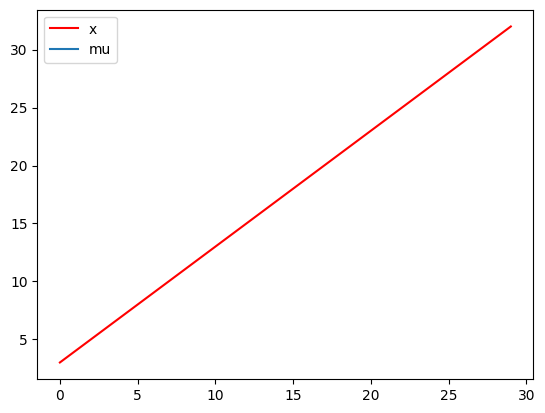

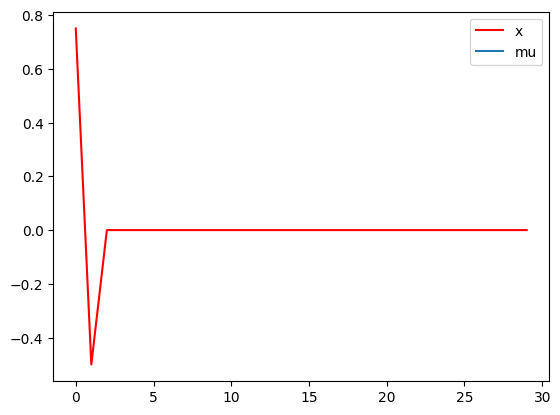

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
0.01


In [56]:
plt.figure()
plt.plot(x, color = "red", label= "x")
plt.plot(mu, label = "mu")
plt.legend()
plt.figure()
plt.plot(x_tilde, color = "red", label= "x")
plt.plot(mu_tilde, label = "mu")
plt.legend()
plt.show()
print(mu)
print(a)

## Simulation with the different methods

In [57]:
t1=time.time()
sim_theta1,sim_theta_tilde1,sim_accepts1,sim_gammas1, Mean1,end_source = MetropolisHastings(T,Lambda, Y, 1e5, "source",save=False)
sim_theta2,sim_theta_tilde2,sim_accepts2,sim_gammas2, Mean2,end_image = MetropolisHastings(T,Lambda, Y, 1e5, "image")
sim_theta3,sim_theta_tilde3,sim_accepts3,sim_gammas3, Mean3,end_subdiff_source = MetropolisHastings(T,Lambda, Y, 1e5, "subdiff_source",save=False)
sim_theta4,sim_theta_tilde4,sim_accepts4,sim_gammas4, Mean4,end_subdiff_image = MetropolisHastings(T,Lambda, Y, 1e5, "subdiff_image",save=False)
q = np.array([2.5,50,97.5])
#quantiles_emp1 = Quantiles(sim_theta_tilde1, q,T)
#quantiles_emp2 = Quantiles(sim_theta_tilde2, q,T)
#quantiles_emp3 = Quantiles(sim_theta_tilde3, q,T)
#quantiles_emp4 = Quantiles(sim_theta_tilde4, q,T)
t2=time.time()
print(t2-t1)

223.91694116592407


## Visualisation of theory VS simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


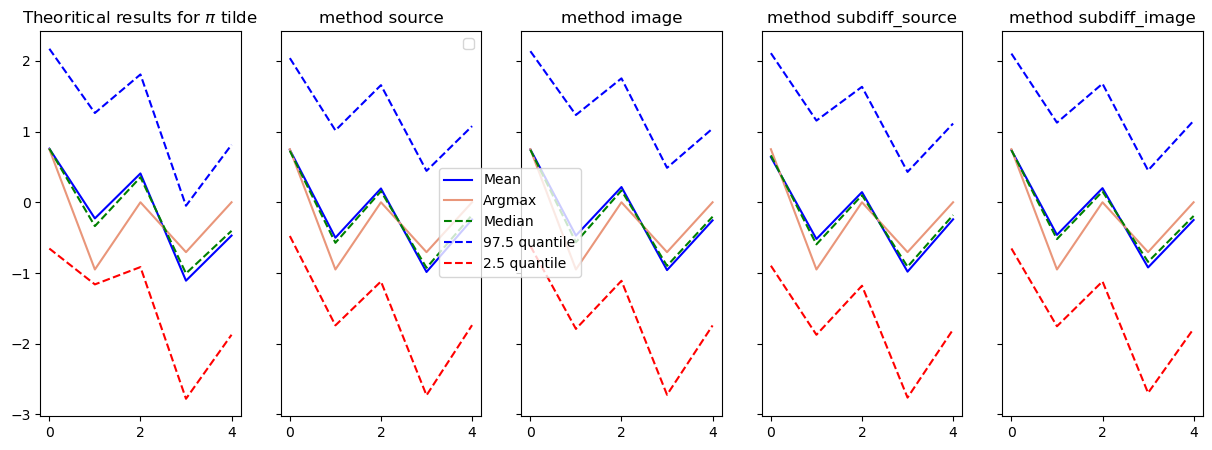

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5), sharey=True)
#Plot of theoritical results
axes[0].plot(mu_tilde,color="blue",label="Mean")
axes[0].plot(x_tilde,color="darksalmon",label="Argmax")
axes[0].plot(med,'g--',label="Median")
axes[0].plot(q1,'b--',label="97.5 quantile")
axes[0].plot(q2,'r--',label="2.5 quantile")
axes[0].set_title("Theoritical results for $\pi$ tilde")


#Plot of empirical results with method source
axes[1].plot(D@Mean1,color="blue")
axes[1].plot(x_tilde,color="darksalmon")
axes[1].plot(quantiles_emp1[1],'g--')
axes[1].plot(quantiles_emp1[2],'b--')
axes[1].plot(quantiles_emp1[0],'r--')
axes[1].set_title("method source")
axes[1].legend()


#Plot of empirical results with method image
axes[2].plot(D@Mean2,color="blue")
axes[2].plot(x_tilde,color="darksalmon")
axes[2].plot(quantiles_emp2[1],'g--')
axes[2].plot(quantiles_emp2[2],'b--')
axes[2].plot(quantiles_emp2[0],'r--')
axes[2].set_title("method image")

#Plot of empirical results with method subdiff_source
axes[3].plot(D@Mean3,color="blue")
axes[3].plot(x_tilde,color="darksalmon")
axes[3].plot(quantiles_emp3[1],'g--')
axes[3].plot(quantiles_emp3[2],'b--')
axes[3].plot(quantiles_emp3[0],'r--')
axes[3].set_title("method subdiff_source")

#Plot of empirical results with method subdiff_image
axes[4].plot(D@Mean4,color="blue")
axes[4].plot(x_tilde,color="darksalmon")
axes[4].plot(quantiles_emp4[1],'g--')
axes[4].plot(quantiles_emp4[2],'b--')
axes[4].plot(quantiles_emp4[0],'r--')
axes[4].set_title("method subdiff_image")
# Shrink current axis by 20%
box0,box1 = axes[0].get_position(),axes[1].get_position()
#axes[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
#axes[1].set_position([box1.x0*0.8, box1.y0, box1.width * 0.8, box1.height])
fig.legend(loc=(0.8*box1.x0+box1.width,box1.height/2))
plt.show()

## Convergence of the empirical mean

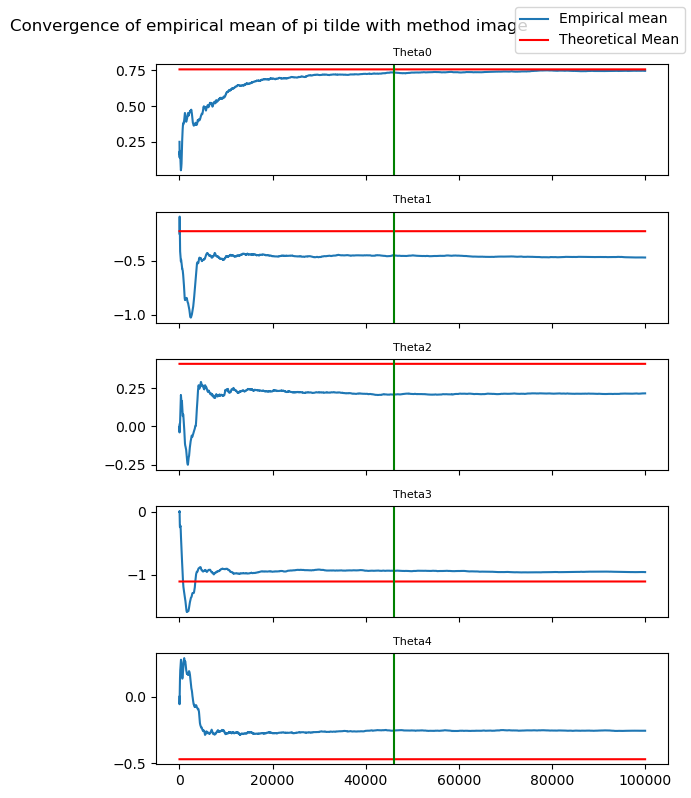

In [38]:
#Convergence plot of the mean of theta_tilde
nb_save=sim_theta2.shape[0]
x=np.linspace(1,nb_save,nb_save)
mean_tab=np.cumsum(sim_theta_tilde2,axis=0)

fig,Axes = plt.subplots(T,1,figsize=(6,8),sharex=True)
for i in range(T):
    ax = Axes[i]
    res=mean_tab[:,i]/x
    ax.plot(x,res,label="Empirical mean" if i==0 else "")
    ax.plot(x,mu_tilde[i]*np.ones(nb_save),'r',label="Theoretical Mean" if i==0 else "")
    ax.axvline(end_image,color="green")
    ax.set_title(f"Theta{i}",fontsize=8)

fig.suptitle("Convergence of empirical mean of pi tilde with method image", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

## Convergence of the acceptance rate

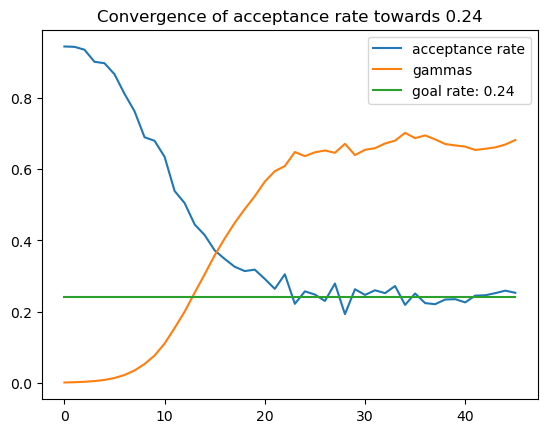

In [39]:
plt.plot(sim_accepts2,label="acceptance rate")
plt.plot(sim_gammas2[:-1],label="gammas")
plt.plot(np.ones(len(sim_accepts2))*0.24,label="goal rate: 0.24")
plt.title("Convergence of acceptance rate towards 0.24")
plt.legend()
plt.show()

## Impact of Lambda
In this part of the notebook, we will estimate $\theta$ under different $\lambda \in \Lambda$. We define a list containing different $\lambda$ and we will create a DataFrame that computes the relative error for every component of $\theta$ 10 times, and we will look at the mean and standard deviation of the relative error for every component.

In [55]:
Lambdas = [0.1] + [0.5*i for i in range(1,10)] + [7.5,10]#np.arange(0.5,5,0.5)#[0.1,0.5,0.8,1,1.3,1.6,2,4,7,9]
T = 5
niter = 1e5
nb_sim = 1
method = "source"
n = len(Lambdas)
sim_theta_tildes = np.zeros((T,10,n))

for k in range(n):
    Y = Y_simu[Lambdas[k]]
    for j in range(nb_sim):
        _, sim_theta_tildes[:,j,k] = MetropolisHastingsFast(T, Lambdas[k], Y,niter=niter,method=method)
        #print("working...")
    print(f"Oooh yeah! Finished {k}. iteration")

Oooh yeah! Finished 0. iteration
Oooh yeah! Finished 1. iteration
Oooh yeah! Finished 2. iteration
Oooh yeah! Finished 3. iteration
Oooh yeah! Finished 4. iteration
Oooh yeah! Finished 5. iteration
Oooh yeah! Finished 6. iteration
Oooh yeah! Finished 7. iteration
Oooh yeah! Finished 8. iteration
Oooh yeah! Finished 9. iteration
Oooh yeah! Finished 10. iteration
Oooh yeah! Finished 11. iteration


In [8]:
print(pd.DataFrame(sim_theta_tildes[:,:,-1]))

          0         1         2         3         4         5         6  \
0  0.841765  0.870489  0.928716  0.810797  0.860263  0.879840  0.966898   
1 -1.019185 -0.996673 -1.010098 -1.047158 -1.018617 -1.000986 -0.990590   
2 -0.056401 -0.039715 -0.046954 -0.085888 -0.056417 -0.035674 -0.035819   
3  1.169486  1.304447  1.572516  0.777537  1.250766  1.385107  1.440637   
4  0.008437  0.010047  0.009424  0.000820  0.012038  0.011529  0.011742   

          7         8         9  
0  0.850533  0.832816  0.846725  
1 -1.032069 -1.021816 -1.008159  
2 -0.067624 -0.056011 -0.044765  
3  0.929876  1.050684  1.251325  
4  0.006722  0.009254  0.010817  


The simulated $\theta$ sometimes takes tiny values close to 0, although the theoretical value is a bigger real number. This means that the relative error can exaggerate the magnitude of the error, since we divide by a small number. Therefore we opt for the following error:
$d(x,y) = \frac{|x-y|}{max(|x|,|y|}$

In [9]:
def dist(x,y):
    return np.abs(x-y)/np.maximum(np.abs(x),np.abs(y))

In [10]:
a = np.array([1,2,3,4])
b = np.array([3,4,8,9])
dist(a,b)

array([0.66666667, 0.5       , 0.625     , 0.55555556])

In [12]:
errors = np.zeros(np.shape(sim_theta_tildes))
for k in range(n):
    Y = Y_simu[Lambdas[k]]
    _, theoretical_means = ComputeMeans(T, Lambdas[k], Y)
    errors[:,:,k] = dist(sim_theta_tildes[:,:,k],theoretical_means[:,np.newaxis] @ np.ones((1,nb_sim)))
    #errors[:,:,k] = abs(sim_theta_tildes[:,:,k] - theoretical_means[:,np.newaxis] @ np.ones((1,10))) / np.max(np.abs(sim_theta_tildes[:,:,k])

In [14]:
print(np.shape(errors))
data = np.zeros((T,2*n))
for i in range(n//2+1):
    data[:,2*i] = np.mean(errors[:,:,i],axis=1)
    data[:,2*i+1]=np.std(errors[:,:,i],axis=1)
assert np.shape(data)==(T,2*n)
df = pd.DataFrame(data)

df.columns = pd.MultiIndex.from_product([Lambdas,["mean","std"]],names=["lambdas","measure"])

(5, 10, 12)


In [15]:
df

array([[0.7168804 , 0.70721938, 0.68763512, 0.72729596, 0.71065858,
        0.70407399, 0.67479287, 0.71393137, 0.71989014, 0.71521217],
       [0.13393524, 0.11437304, 0.12614425, 0.15707083, 0.13345232,
        0.11818966, 0.1089351 , 0.1447471 , 0.13616527, 0.12446378],
       [1.00590566, 1.00415848, 1.00491646, 1.00899321, 1.00590728,
        1.00373532, 1.00375056, 1.0070808 , 1.00586485, 1.00468724],
       [0.88209139, 0.86848457, 0.84145754, 0.921608  , 0.87389674,
        0.86035231, 0.85475375, 0.90624912, 0.89406912, 0.87384032],
       [0.99915548, 0.99899438, 0.99905668, 0.99991794, 0.99879505,
        0.99884594, 0.9988247 , 0.99932719, 0.99907374, 0.99891725]])

In [20]:
df_mean = df.mean()


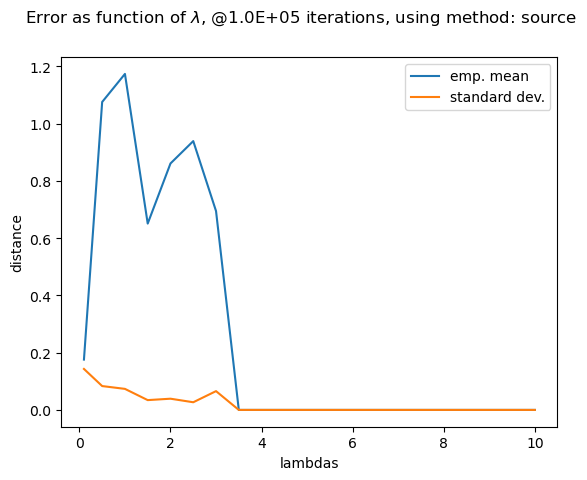

In [49]:
fig,ax = plt.subplots(1,1)
df_mean.xs("mean", level=1, axis=0).plot(label="emp. mean")
df_mean.xs("std",  level=1, axis=0).plot(label="standard dev.")
fig.suptitle(f"Error as function of $\lambda$, @{niter:.1E} iterations, using method: {method}")
ax.set_ylabel("distance")
ax.legend()
plt.show()

## L1 VS L2 contributions and Log-Pi Distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


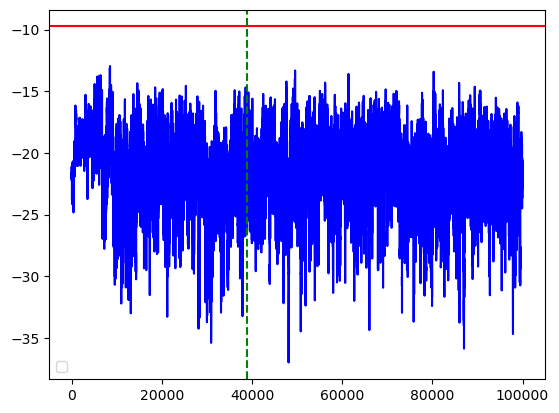

In [47]:
plt.figure()
#print(sim_theta)
#print(LogDistributionPi_Tab(sim_theta, Y, A, D, sh, Lambda))
T = 20
Lambda = 1
#Y = Y_simu[Lambda]
Y=Computation_Y(T,Lambda)
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T, a, b)
theta_tab, theta_tilde_tab, accepts, gammas, theta_mean,end_subdiff_source = MetropolisHastings(T, Lambda, Y, method = "subdiff_source")
plt.plot(LogDistributionPi_Tab(theta_tab, Y, A, D, sh, Lambda), color = "blue")
#plt.plot(L1_tab, color = "green",alpha=0.2,label="L1")
#plt.plot(L2_tab, color = "black",alpha=0.2,label="L2")
plt.axhline(LogDistributionPi(ComputeArgmax(T, Lambda, Y)[0], Y, A, D, sh, Lambda), color = "red")
plt.axvline(end_subdiff_source,color="green",linestyle="--")
plt.legend()
plt.show()

Hopefully, the LogPi Distibution of the chain is always lower than the LogPi of the Argmax (as it is the maximum value).

Studying Pi Distribution of our chain and comparing to argmax (the chain should oscillate around the argmax when enough
iterations are done)

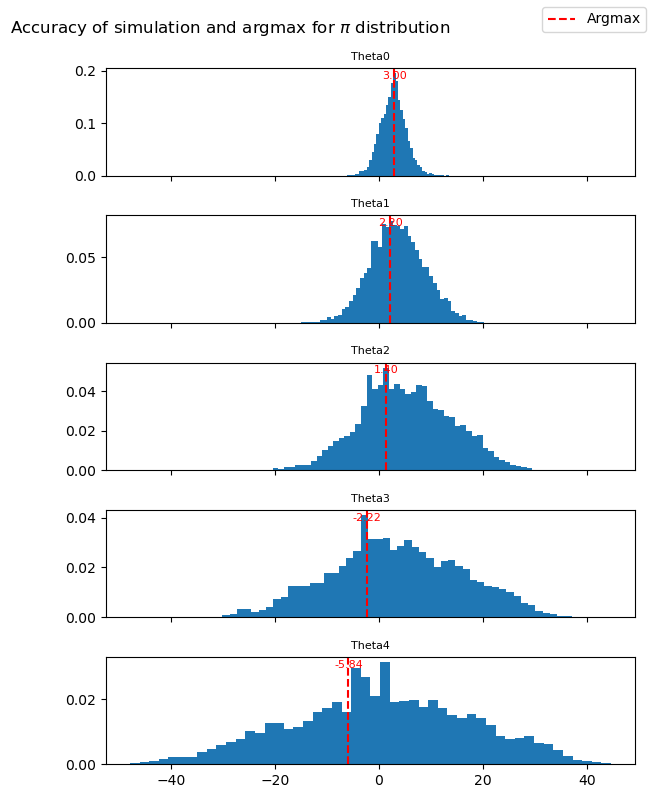

In [44]:
fig, axes = plt.subplots(nrows=T, ncols=1, figsize=(6, 8), sharex=True)
nb_save=theta_tab.shape[0]
argmax=ComputeArgmax(T, Lambda, Y)[0]
for i in range(T):
    ax = axes[i]
    ax.hist(theta_tab[:,i],bins=50,density=True)
    ax.plot(argmax[i],0,color='red')
    ax.axvline(argmax[i], color='red', linestyle='dashed', label="Argmax" if i==0 else "")
    ax.text(argmax[i], ax.get_ylim()[1] * 0.9, f"{argmax[i]:.2f}", 
            color='red', fontsize=8, ha='center')
    ax.set_title(f"Theta{i}",fontsize=8)


fig.suptitle("Accuracy of simulation and argmax for $\pi$ distribution", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

We can see that for the first components, the distibution of the simulation is quite well gaussian and we find quite well the argmax but as we increase the dimensions, this becomes less and less accurate, the distribution variance increases very fast and the distribution of the simulation seems to diverge to the real one as the argmax is not anymore equal to the graphic one.

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\arman\AppData\Local\Temp\ipykernel_16432\460066343.py:14: SyntaxWarning: invalid escape sequence '\p'
  fig.suptitle("Accuracy of simulation and argmax for $\tilde\pi$ distribution", x=0.3)


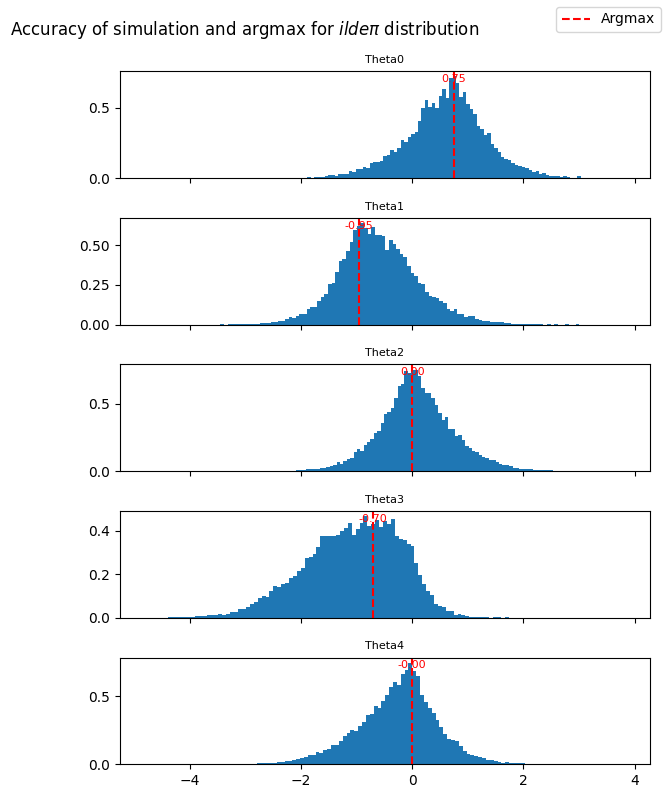

In [7]:
fig, axes = plt.subplots(nrows=T, ncols=1, figsize=(6, 8), sharex=True)
nb_save=theta_tab.shape[0]
argmax=ComputeArgmax(T, Lambda, Y)[1]
for i in range(T):
    ax = axes[i]
    ax.hist(theta_tilde_tab[:,i],bins=100,density=True)
    ax.plot(argmax[i],0,color='red')
    ax.axvline(argmax[i], color='red', linestyle='dashed', label="Argmax" if i==0 else "")
    ax.text(argmax[i], ax.get_ylim()[1] * 0.9, f"{argmax[i]:.2f}", 
            color='red', fontsize=8, ha='center')
    ax.set_title(f"Theta{i}",fontsize=8)


fig.suptitle("Accuracy of simulation and argmax for pi_tilde distribution", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

The result is better for the $\tilde\pi$ distribution, the symmetry and variance stay quite the same for every component and the graphic argmax is in accordance with the theoritical one.

done1
7.28170125972202
4.5800035259582454
4.388374498446397
5.576682636676082


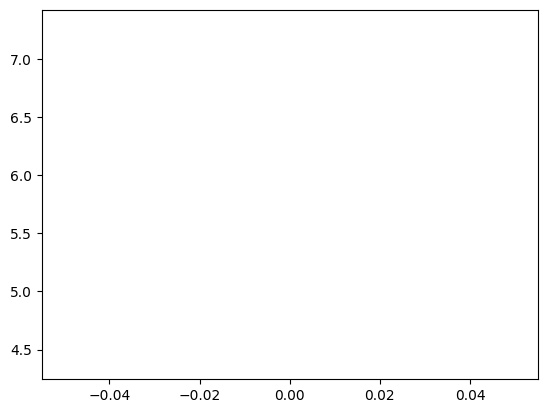

In [7]:
T = 3
Lambdas = [0.1] #+ [0.5*i for i in range(1,5)] #+ [7.5,10]
Y_simu=Create_DicoY(T,Lambdas)
n_simu = len(Lambdas)
theoretical_means = np.zeros((n_simu, T))
errors_source = np.zeros(n_simu)
errors_image = np.zeros(n_simu)
errors_subdiff_source = np.zeros(n_simu)
errors_subdiff_image = np.zeros(n_simu)

for i in range(n_simu):
    #print(ComputeMeans(T, 1, Y_simu[Lambdas[i]])[0])
    theoretical_means[i,:] = ComputeMeans(T, 1, Y_simu[Lambdas[i]])[0]
    print("done1")
    errors_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="source")[0]-theoretical_means[i,:]))
    print(errors_source[i])
    errors_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="image")[0]-theoretical_means[i,:]))
    print(errors_image[i])
    errors_subdiff_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="subdiff_source")[0]-theoretical_means[i,:]))
    print(errors_subdiff_source[i])
    errors_subdiff_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="subdiff_image")[0]-theoretical_means[i,:]))
    print(errors_subdiff_image[i])

plt.figure()
plt.plot(errors_source, color = "blue")
plt.plot(errors_image, color = "green")
plt.plot(errors_subdiff_source, color = "red")
plt.plot(errors_subdiff_image, color = "black")
plt.show()

## Methods Comparison

Comparaison pour plusieurs valeurs de Lambda, erreur en norme 1 entre les moyennes empiriques et les moyennes théoriques pour différentes méthodes. Les moyennes empiriques sont obtenues après 10^5 itérations, une fois burn-in fini. La méthode source, image, subdiff_image fournissent des résultats similaires, la méthode subdiff_source fournit des résultats beaucoup moins bons : la convergence prend beaucoup de temps, ou, plus probable, il y a un problème dans la formulation de la méthode.

### Différence entre les valeurs simulés et l'argmax en erreur relative (Comparaison à lambda fixé)

In [11]:
T = 10
Lambda = 1
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T)
Y_simu=Create_DicoY(T,[Lambda])
Y = Y_simu[Lambda]
theta_tab_source,_,_,_,_,end_source = MetropolisHastings(T, Lambda, Y, 1e5, "source")
theta_tab_image,_,_,_,_,end_image = MetropolisHastings(T, Lambda, Y, 1e5, "image")
theta_tab_subdiff_source,_,_,_,_,end_subdiff_source = MetropolisHastings(T, Lambda, Y, 1e5, "subdiff_source")
theta_tab_subdiff_image,_,_,_,_,end_subdiff_image = MetropolisHastings(T, Lambda, Y, 1e5, "subdiff_image")

In [61]:
T = 10
Lambda = 1
D = BuildD(T)
D1 = npl.solve(D, np.identity(T))
print(D1@D1.T)
print(D@D.T)

[[  16.   32.   48.   64.   80.   96.  112.  128.  144.  160.]
 [  32.   80.  128.  176.  224.  272.  320.  368.  416.  464.]
 [  48.  128.  224.  320.  416.  512.  608.  704.  800.  896.]
 [  64.  176.  320.  480.  640.  800.  960. 1120. 1280. 1440.]
 [  80.  224.  416.  640.  880. 1120. 1360. 1600. 1840. 2080.]
 [  96.  272.  512.  800. 1120. 1456. 1792. 2128. 2464. 2800.]
 [ 112.  320.  608.  960. 1360. 1792. 2240. 2688. 3136. 3584.]
 [ 128.  368.  704. 1120. 1600. 2128. 2688. 3264. 3840. 4416.]
 [ 144.  416.  800. 1280. 1840. 2464. 3136. 3840. 4560. 5280.]
 [ 160.  464.  896. 1440. 2080. 2800. 3584. 4416. 5280. 6160.]]
[[ 0.0625 -0.125   0.0625  0.      0.      0.      0.      0.      0.
   0.    ]
 [-0.125   0.3125 -0.25    0.0625  0.      0.      0.      0.      0.
   0.    ]
 [ 0.0625 -0.25    0.375  -0.25    0.0625  0.      0.      0.      0.
   0.    ]
 [ 0.      0.0625 -0.25    0.375  -0.25    0.0625  0.      0.      0.
   0.    ]
 [ 0.      0.      0.0625 -0.25    0.375  -0.

In [50]:
argmax=ComputeArgmax(T, Lambda, Y)[0]

dist_tab_source=np.sum(abs(theta_tab_source-argmax),axis=1)/sum(abs(argmax))
dist_tab_image=np.sum(abs(theta_tab_image-argmax),axis=1)/sum(abs(argmax))
dist_tab_subdiff_source=np.sum(abs(theta_tab_subdiff_source-argmax),axis=1)/sum(abs(argmax))
dist_tab_subdiff_image=np.sum(abs(theta_tab_subdiff_image-argmax),axis=1)/sum(abs(argmax))

[ 3.          2.19913063  1.39826126 -2.2224151  -5.84309146]


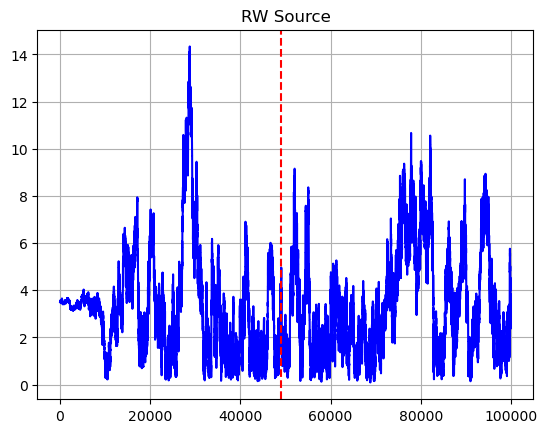

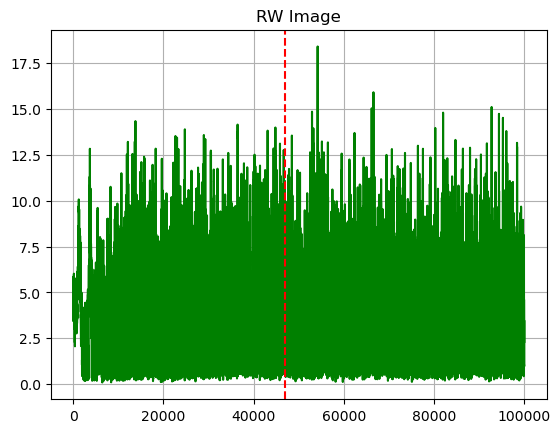

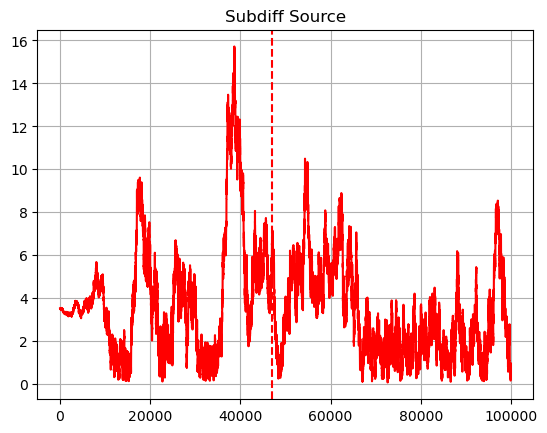

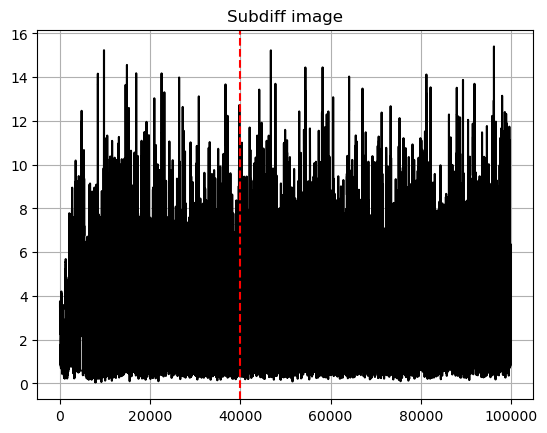

In [51]:
plt.figure()
plt.plot(dist_tab_source, color = "blue")
plt.axvline(end_source,color="red",linestyle="--")
plt.title("RW Source")
plt.grid()
plt.figure()
plt.title("RW Image")
plt.plot(dist_tab_image, color = "green")
plt.axvline(end_image,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff Source")
plt.plot(dist_tab_subdiff_source, color = "red")
plt.axvline(end_subdiff_source,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff image")
plt.plot(dist_tab_subdiff_image, color = "black")
plt.axvline(end_subdiff_image,color="red",linestyle="--")
plt.grid()
print(argmax)

Les méthodes source et image ont des performances similaires entre elles (mêmes types de profils). La méthode qui propose les meilleurs résultats est subdiff_source.

### Différence entre les valeurs simulés et l'argmax évaluées en `LogDistributionPi` en erreur relative (Comparaison à lambda fixé)

In [52]:
logpi_argmax=LogDistributionPi(argmax, Y, A, D, sh, Lambda)

dist_source = abs(LogDistributionPi_Tab(theta_tab_source, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)
dist_image = abs(LogDistributionPi_Tab(theta_tab_image, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)
dist_subdiff_source = abs(LogDistributionPi_Tab(theta_tab_subdiff_source, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)
dist_subdiff_image = abs(LogDistributionPi_Tab(theta_tab_subdiff_image, Y, A, D, sh, Lambda)-logpi_argmax)/abs(logpi_argmax)

-1.9944194069350103


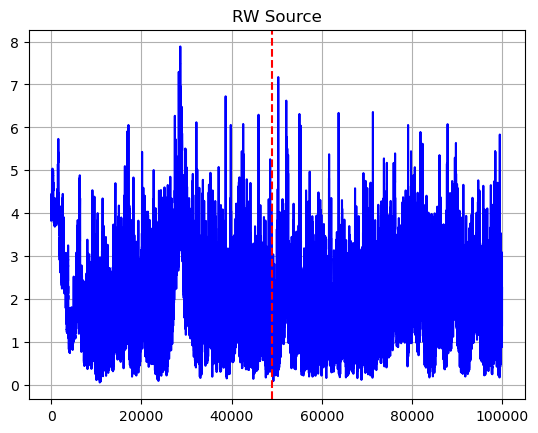

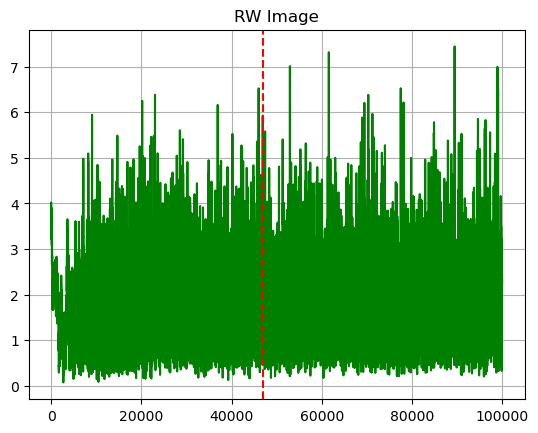

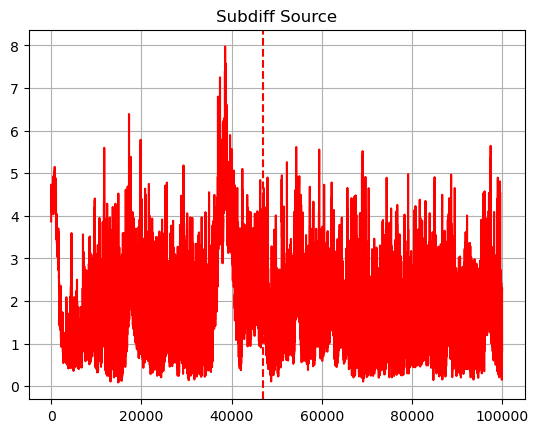

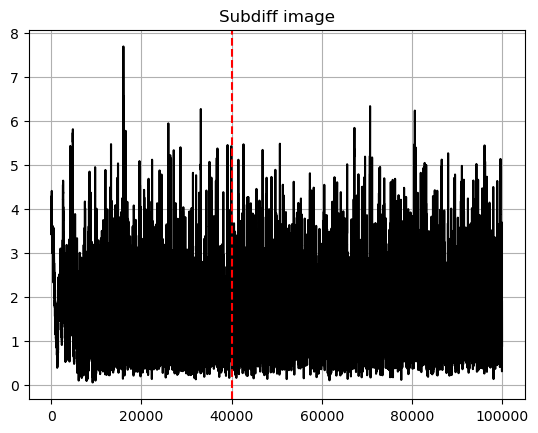

In [53]:
plt.figure()
plt.title("RW Source")
plt.plot(dist_source, color = "blue")
plt.axvline(end_source,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("RW Image")
plt.plot(dist_image, color = "green")
plt.axvline(end_image,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff Source")
plt.plot(dist_subdiff_source, color = "red")
plt.axvline(end_subdiff_source,color="red",linestyle="--")
plt.grid()
plt.figure()
plt.title("Subdiff image")
plt.plot(dist_subdiff_image, color = "black")
plt.axvline(end_subdiff_image,color="red",linestyle="--")
plt.grid()
print(logpi_argmax)